In [2]:
!pip install ppscore


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Libraries
import math, re, os
from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets
import json
import shutil
import zipfile
import re
import tensorflow as tf
import ppscore as pps

# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from joblib import Parallel, delayed

# Data
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

E0000 00:00:1725086665.072962      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0831 06:44:25.081099536      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0831 06:44:25.081114084      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0831 06:44:25.081117352      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0831 06:44:25.081119742      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0831 06:44:25.081122122      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

Tensorflow version 2.16.1


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1725086680.325496      13 service.cc:145] XLA service 0x5c1941528150 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725086680.325546      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1725086680.325550      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1725086680.325553      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1725086680.325556      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1725086680.325559      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1725086680.325562      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1725086680.325564      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1725086680.325567      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [12]:
!pip install --upgrade kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 7.3 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=e46660bad3fdb2547b8ad2afcbae622950708ae7163490b3829b2f09fa238b99
  Stored in directory: /root/.cache/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
# Kaggle API Using Secrets

from kaggle_secrets import UserSecretsClient

# Brought key info
user_secrets = UserSecretsClient()
kaggle_key = user_secrets.get_secret("jiyoungroh")

# Setting
os.environ['KAGGLE_KEY'] = kaggle_key
os.environ['KAGGLE_USERNAME'] = "jiyoungroh"

In [15]:
!kaggle competitions download -c playground-series-s4e8

 92%|████████████████████████████████████   | 76.0M/82.3M [00:00<00:00, 246MB/s]
100%|███████████████████████████████████████| 82.3M/82.3M [00:00<00:00, 226MB/s]


In [16]:
# Unzip
with zipfile.ZipFile('/kaggle/working/playground-series-s4e8.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

# Loading Data
train_data = pd.read_csv('/kaggle/working/train.csv')
test_data = pd.read_csv('/kaggle/working/test.csv')
sample_submission = pd.read_csv('/kaggle/working/sample_submission.csv')

In [17]:
pd.set_option('display.max_columns', None)
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


# 1. Feature Selection

## 1-1. PPS for entire variable

In [18]:
pp_scores = []

for col in train_data.columns[1:]:
    pp_score = pps.score(train_data, col, "class")["ppscore"]
    pp_scores.append(pp_score)

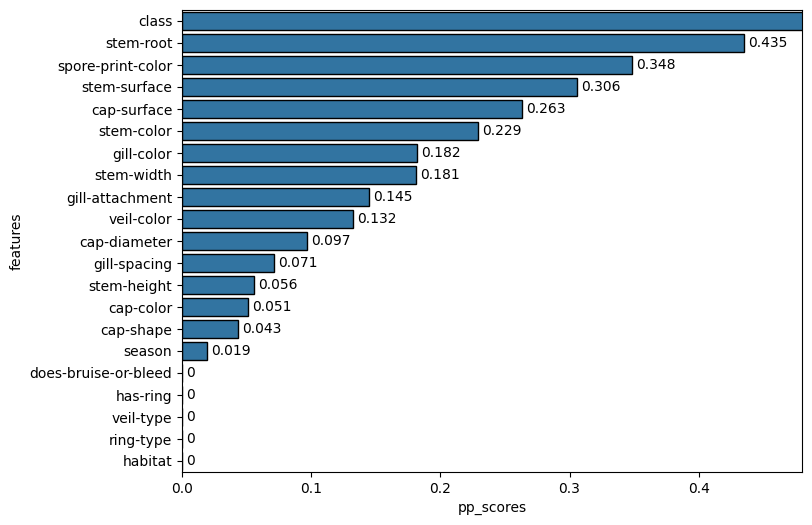

In [19]:
data = pd.DataFrame({
    "features": list(train_data.columns[1:]),
    "pp_scores": np.round(pp_scores, 3)
}).sort_values("pp_scores", ascending = False)

plt.figure(figsize = (8, 6))
ax = sns.barplot(data, x = "pp_scores", y = "features", edgecolor = "#000000")

for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=10)
    
plt.xlim(0, 0.48)
plt.show()

In [20]:
def print_poisonous_percentage(col, unique_val):
    n_rows = train_data[train_data[col] == unique_val].shape[0]
    print(f"Rows with value of {unique_val}:", n_rows)
    print("Edible %:", round(train_data[train_data[col] == unique_val]["class"].value_counts(True).iloc[0], 3))
    print("Posionous %:", round(train_data[train_data[col] == unique_val]["class"].value_counts(True).iloc[1], 3))
    print()
    return n_rows

def print_vals(col, vals):
    n_rows = 0
    for val in vals:
        n_rows += print_poisonous_percentage(col = col, unique_val = val)
    print("Total rows", n_rows)

In [21]:
print_vals(col = "stem-root", vals = ["r", "c", "f"])

Rows with value of r: 47803
Edible %: 0.995
Posionous %: 0.005

Rows with value of c: 28592
Edible %: 0.996
Posionous %: 0.004

Rows with value of f: 597
Edible %: 0.988
Posionous %: 0.012

Total rows 76992


In [22]:
print_vals(col = "spore-print-color", vals = ["n", "r", "u", "g"])

Rows with value of n: 22646
Edible %: 0.997
Posionous %: 0.003

Rows with value of r: 7975
Edible %: 0.997
Posionous %: 0.003

Rows with value of u: 7256
Edible %: 0.997
Posionous %: 0.003

Rows with value of g: 3492
Edible %: 0.972
Posionous %: 0.028

Total rows 41369


In [23]:
print_vals(col = "stem-surface", vals = ["g", "h", "f"])

Rows with value of g: 78080
Edible %: 0.996
Posionous %: 0.004

Rows with value of h: 28283
Edible %: 0.996
Posionous %: 0.004

Rows with value of f: 512
Edible %: 0.99
Posionous %: 0.01

Total rows 106875


In [24]:
print_vals(col = "stem-color", vals = ["b", "f"])

Rows with value of b: 7365
Edible %: 0.994
Posionous %: 0.006

Rows with value of f: 573
Edible %: 0.981
Posionous %: 0.019

Total rows 7938


## 1-2. Numeric Correlationship with Class

### 1-2-1. Numeric Correlation

In [26]:
# Transform class to numeric
train_data['class'] = train_data['class'].map({'e': 0, 'p': 1})

# select numeric
numeric_columns = ['cap-diameter', 'stem-height', 'stem-width']

# compute correlationship between class and numeric
correlations = train_data[numeric_columns + ['class']].corr()['class'][:-1]  # class와의 상관관계만 추출
print(correlations)

cap-diameter   -0.162626
stem-height    -0.049740
stem-width     -0.169807
Name: class, dtype: float64


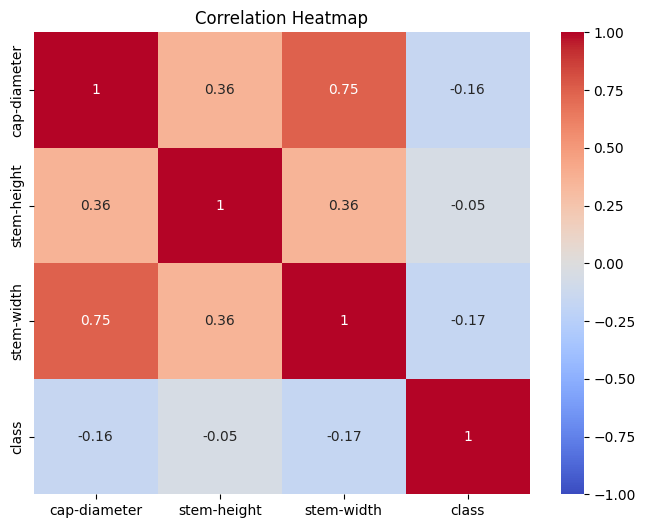

In [27]:
# 상관관계 행렬 계산
corr_matrix = train_data[numeric_columns + ['class']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

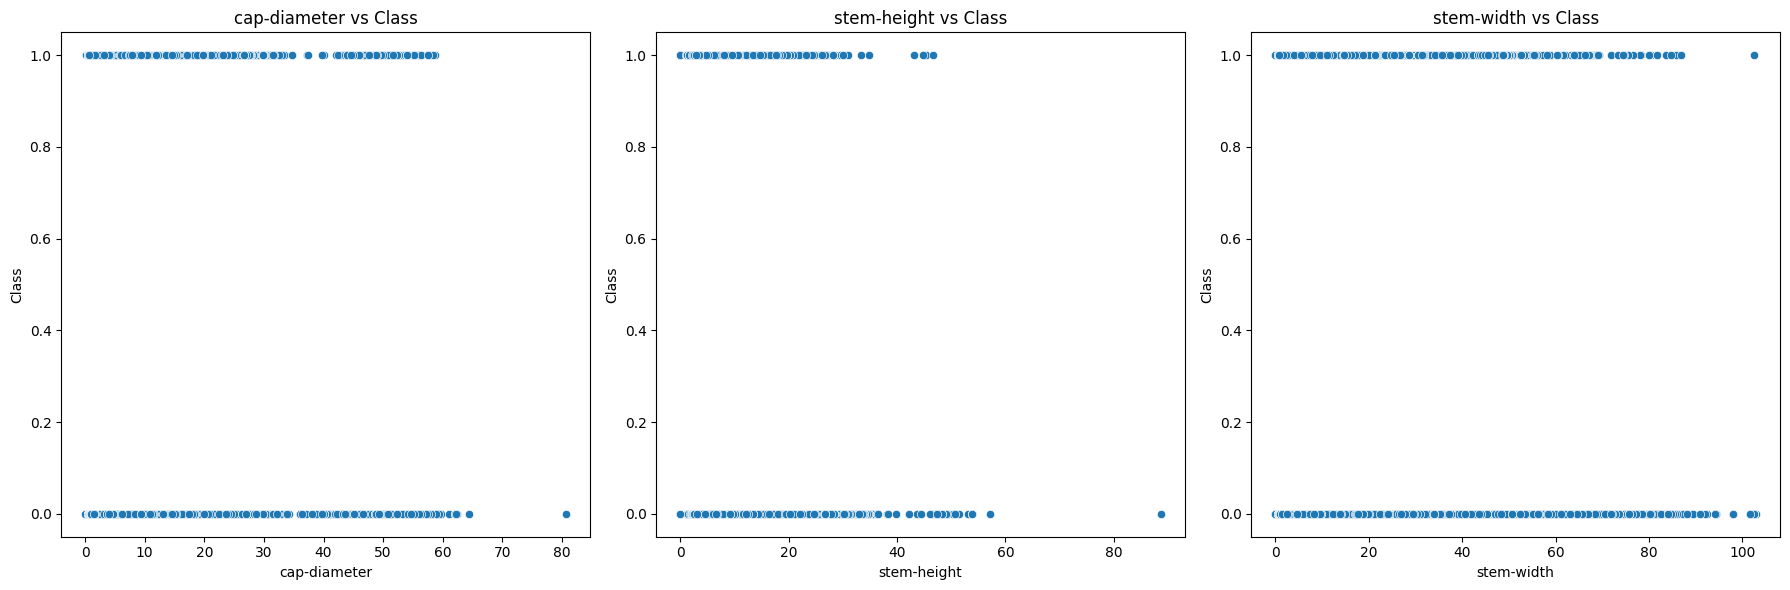

In [28]:
plt.figure(figsize=(18, 6))

for i, col in enumerate(numeric_columns):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=train_data[col], y=train_data['class'])
    plt.title(f'{col} vs Class')
    plt.xlabel(col)
    plt.ylabel('Class')

plt.tight_layout()
plt.show()

Numeric Feture Selection Option 
- Remove every numeric class except 'stem-width' 
- Preserve every numeric class and after analyze result, remove 'cap-diameter' and 'stem-height'

In [42]:
selected_numeric = ['stem-width']

## 2-1. Categoric class relationship with class 

### 2-1-1. Chi-Square Test

In [29]:
from scipy.stats import chi2_contingency

In [30]:
categoric_columns = [
    'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 
    'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 
    'stem-surface', 'stem-color', 'veil-type', 'veil-color', 
    'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'
]

# categoric_columns
print(categoric_columns)

['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [32]:
# Chi-Square-Test
def chi_square_test(train_data, column):
    contingency_table = pd.crosstab(train_data['class'], train_data[column])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p

# Chi-Square Test Result List
chi_square_results = []

# Run chi square for each categoric columns
for column in categoric_columns:
    chi2, p = chi_square_test(train_data, column)
    chi_square_results.append((column, chi2, p))

# sort
chi_square_results.sort(key=lambda x: x[1], reverse=True)

for result in chi_square_results:
    print(f"Column: {result[0]}, Chi-Square: {result[1]}, p-value: {result[2]}")

Column: cap-color, Chi-Square: 208410.46720740022, p-value: 0.0
Column: stem-color, Chi-Square: 206409.5401305069, p-value: 0.0
Column: cap-surface, Chi-Square: 196261.23785709386, p-value: 0.0
Column: gill-color, Chi-Square: 150920.89339649005, p-value: 0.0
Column: gill-attachment, Chi-Square: 147464.47331916308, p-value: 0.0
Column: stem-surface, Chi-Square: 144948.87918235935, p-value: 0.0
Column: ring-type, Chi-Square: 115736.23500277763, p-value: 0.0
Column: habitat, Chi-Square: 98422.14447448973, p-value: 0.0
Column: stem-root, Chi-Square: 97654.82396351731, p-value: 0.0
Column: veil-color, Chi-Square: 92466.93895813727, p-value: 0.0
Column: cap-shape, Chi-Square: 87533.89773815623, p-value: 0.0
Column: season, Chi-Square: 69393.16710620302, p-value: 0.0
Column: spore-print-color, Chi-Square: 48444.31368074108, p-value: 0.0
Column: gill-spacing, Chi-Square: 36586.169994482014, p-value: 0.0
Column: has-ring, Chi-Square: 7715.841488267846, p-value: 0.0
Column: does-bruise-or-bleed,

remove veil-type

### 2-1-2. Cramer's V

In [33]:
from scipy.stats import chi2_contingency

In [34]:
# Cramér's V 계산 함수
def cramers_v(train_data, column):
    contingency_table = pd.crosstab(train_data['class'], train_data[column])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()  # 표의 총 데이터 수
    min_dim = min(contingency_table.shape) - 1  # 카테고리 변수의 최소 차원
    return np.sqrt(chi2 / (n * min_dim))

# 각 카테고리 변수에 대해 Cramér's V 계산
cramers_v_results = []
for column in categoric_columns:
    cv = cramers_v(train_data, column)
    cramers_v_results.append((column, cv))

# Cramér's V 값으로 내림차순 정렬
cramers_v_results.sort(key=lambda x: x[1], reverse=True)

# 정렬된 결과 출력
for result in cramers_v_results:
    print(f"Column: {result[0]}, Cramér's V: {result[1]}")

Column: stem-root, Cramér's V: 0.520885962925066
Column: veil-color, Cramér's V: 0.4959072676433823
Column: spore-print-color, Cramér's V: 0.4257473802241635
Column: stem-surface, Cramér's V: 0.3571923993372263
Column: cap-surface, Cramér's V: 0.28326698831439157
Column: cap-color, Cramér's V: 0.25858065433019356
Column: stem-color, Cramér's V: 0.25733743093758404
Column: gill-attachment, Cramér's V: 0.23847435890870208
Column: gill-color, Cramér's V: 0.22004630748878573
Column: ring-type, Cramér's V: 0.19680659830911812
Column: habitat, Cramér's V: 0.17769899730679842
Column: cap-shape, Cramér's V: 0.16758160704788502
Column: season, Cramér's V: 0.1492085758124336
Column: gill-spacing, Cramér's V: 0.14030592873570533
Column: has-ring, Cramér's V: 0.04975408583110642
Column: does-bruise-or-bleed, Cramér's V: 0.03771020194582898
Column: veil-type, Cramér's V: 0.01185222840785297


over 0.5: stem-root

0.3-0.5: veil-color, spore-print-color, stem-surface

0.1-0.3: cap-surface, cap-color, stem-color, gill-attachment, gill-color, ring-type, habitat, cap-shape, season, gill-spacing



REMOEVE LIST :)
under 0.1: has-ring, does-bruise-or-bleed, veil-type

### 2-1-3. Theils U

In [35]:
from scipy.stats import entropy

In [38]:
# Theil's U 계산 함수 (수정)
def conditional_entropy(x, y):
    # x: feature, y: target
    y_counter = pd.value_counts(y)
    xy_counter = pd.crosstab(x, y)

    total_occurrences = sum(y_counter)
    entropy_xy = 0.0

    for x_val, occurrences in xy_counter.iterrows():
        sum_occurrences = sum(occurrences)
        entropy_x = 0.0
        for y_val, count in occurrences.items():
            p_xy = count / total_occurrences
            p_y_given_x = count / sum_occurrences
            if p_y_given_x > 0:
                entropy_x -= p_xy * np.log2(p_y_given_x)
        entropy_xy += entropy_x

    return entropy_xy

def theils_u(x, y):
    s_xy = conditional_entropy(x, y)
    s_y = entropy(pd.value_counts(y, normalize=True), base=2)
    if s_y == 0:
        return 1
    else:
        return (s_y - s_xy) / s_y

# 각 카테고리 변수에 대해 Theil's U 계산
theils_u_results = []
for column in categoric_columns:
    u = theils_u(train_data[column], train_data['class'])
    theils_u_results.append((column, u))

# Theil's U 값으로 내림차순 정렬
theils_u_results.sort(key=lambda x: x[1], reverse=True)

# 정렬된 결과 출력
for result in theils_u_results:
    print(f"Column: {result[0]}, Theil's U: {result[1]}")

Column: veil-type, Theil's U: 0.952173036908611
Column: spore-print-color, Theil's U: 0.9410908156483916
Column: stem-root, Theil's U: 0.9154725883665562
Column: veil-color, Theil's U: 0.9087422021939243
Column: stem-surface, Theil's U: 0.6867180405944311
Column: gill-spacing, Theil's U: 0.41009889769733976
Column: cap-surface, Theil's U: 0.2666890188545589
Column: gill-attachment, Theil's U: 0.19960378960630049
Column: ring-type, Theil's U: 0.07943423893941857
Column: cap-color, Theil's U: 0.052487198378172666
Column: stem-color, Theil's U: 0.05037805113508278
Column: gill-color, Theil's U: 0.03589768016691587
Column: habitat, Theil's U: 0.02638914527609519
Column: cap-shape, Theil's U: 0.021542537289836055
Column: season, Theil's U: 0.01618396112525569
Column: has-ring, Theil's U: 0.0018160567289570982
Column: does-bruise-or-bleed, Theil's U: 0.0010343360196662995


Contain Model: veil-type, spore-print-color, stem-root, veil-color

Have to check after model result:  stem-surface, gill-spacing

Remove?:  has-ring, does-bruise-or-bleed

#### Categoric Feature Result
must have it girl: stem-root, veil-color, spore-print-color, stem-surface

Maybe but YES!: gill-spacing, cap-surface, gill-attachment

Afraid we can't go together: veil-type, has-ring, does-bruise-or-bleed

In [43]:
selected_categoric= ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 
                    'stem-surface', 'stem-color', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']

In [44]:
print(selected_numeric)

['stem-width']


In [45]:
print(selected_categoric)

['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']
